# FASHION MNIST 

**Prepare data**

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import sklearn.model_selection as ms

In [3]:
batch_size = 256

In [17]:
transform_train = transforms.Compose(
    [   transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]
)

transform_test = transforms.Compose(
    [   transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]
)

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform_train, download=True)

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=batch_size, num_workers=2, drop_last=True) #shuffled at each epoch

train_indexes, val_indexes = ms.train_test_split(list(range(len(trainset))), train_size=0.9, shuffle=True, random_state=42)
validation_set = torch.utils.data.Subset(trainset, val_indexes)
trainset = torch.utils.data.Subset(trainset, train_indexes)

valloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False)




**define network**

In [5]:
NUM_CLASSES = 10
n1 = 1000
n2= 200

In [5]:

import torch.nn.functional as F
import torch.nn as nn


class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, n1)
        self.fc2 = nn.Linear(n1, n2)
        self.fc3 = nn.Linear(n2, NUM_CLASSES)
        

    def forward(self, x):
        x = torch.flatten(x, 1) #ci dice da che dimensione fare il flatten, cioe se ho piu batch e quindi x.size = (batch_size, 3, 28, 28)
        #alla fine avro x=(batch_size, 2352)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) #logits presi da cross entropy loss criterion con softmax all'interno
        return x
    


**training**

In [7]:
from torch import optim 

NUM_EPOCHS = 10
lr1 = 1
lr2 = 1e-1
lr3 = 1e-2

criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer):
    validation_losses_epochs = [] #contains losses after each batch
    train_losses_epochs = [] #same

    train_accuracy_epochs = []
    validation_accuracy_epochs = []

    model.to(device)

    for epoch in range(NUM_EPOCHS):
        model.train()
        train_corrects = 0
        total_loss = 0
        num_samples = 0
        print(f'Starting training for epoch {epoch}')


        for i, batch in enumerate(train_loader):

            bs = batch[0].shape[0]
            num_samples += bs
            images, targets = batch
            images , targets = images.to(device), targets.to(device)

            optimizer.zero_grad()

            preds= model(images) 
            #preds e un tensore di logits, quindi per ogni immagine, c'e un tensore 1d con i logit, uno per classe
            # --> il primo indice, cioe l'indice del'intero vettore logits, indica l'immagine a cui il vettore si riferisce
            # --> l'indice dentro i logits corrisponde al numero del target rispetto al quale e stato calcolato quel logit
            #in tutto cio lo shape ha sempre (batch_size,) all'inizio

            _, targets_pred = torch.max(preds, 1)

            train_corrects += torch.sum(targets == targets_pred).item()

            loss = criterion(preds, targets)

            loss.backward()

            optimizer.step()

            
            total_loss += loss.item() * bs
        
        train_losses_epochs.append(total_loss/num_samples)
        
        print(f'Train loss for epoch {epoch}: {total_loss/num_samples:.4f}')
        
        train_accuracy_epochs.append(1.0*train_corrects/float(num_samples))
        


        model.eval()
        val_corrects = 0
        total_loss=0
        num_samples = 0

        with torch.no_grad():
            for batch in val_loader:
                images, targets = batch
                images, targets = images.to(device), targets.to(device) 

                bs = batch[0].shape[0]
                num_samples+=bs
                preds = model(images)

                _, targets_pred = torch.max(preds, 1) #prendo, per ogni tensore logit (percio c'e dim=1, gli stiamo dicendo di calcolare il massimo per ogni singolo vettore logit, non un solo massimo tra tutti i vettori logit), l'indice del logit massimo, ovvero il target con probabilita maggiore
                #cioe che ritorna e un vettore con tutti i logits massimi, uno per immagine appunto
                #e gli indici interni al vettore di logits associati ai singoli logit massimi, ovvero i target, che sono quelli che prendiamo e che ci interessano
                #in tutto cio lo shape ha sempre (batch_size,) all'inizio

                val_corrects += torch.sum(targets == targets_pred).item()

                loss = criterion(preds, targets)

                total_loss += loss.item() * bs

            validation_accuracy_epochs.append(1.0*val_corrects/float(num_samples))

            validation_losses_epochs.append(total_loss/num_samples)

    return validation_losses_epochs, train_losses_epochs, validation_accuracy_epochs, train_accuracy_epochs

**perform training and evaluate results**

- with lr=1 we have gradient explosion

Starting training for epoch 0
Train loss for epoch 0: nan
Starting training for epoch 1
Train loss for epoch 1: nan
Starting training for epoch 2
Train loss for epoch 2: nan
Starting training for epoch 3
Train loss for epoch 3: nan
Starting training for epoch 4
Train loss for epoch 4: nan
Starting training for epoch 5
Train loss for epoch 5: nan
Starting training for epoch 6
Train loss for epoch 6: nan
Starting training for epoch 7
Train loss for epoch 7: nan
Starting training for epoch 8
Train loss for epoch 8: nan
Starting training for epoch 9
Train loss for epoch 9: nan


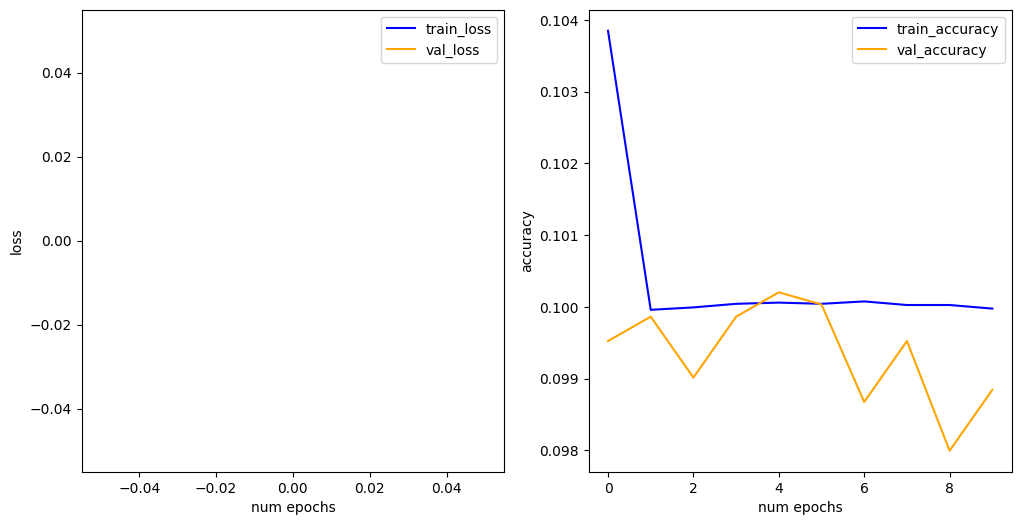

In [10]:
import matplotlib.pyplot as plt

net = MLP()
optimizer = optim.SGD(net.parameters(), lr=lr1, momentum=0.9)


validation_losses_batches, train_losses_batches, validation_accuracy_epochs, train_accuracy_epochs = train_model(net, trainloader, valloader, criterion, optimizer)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(train_losses_batches, c='blue', label='train_loss')
ax[0].plot(validation_losses_batches, c='orange', label='val_loss')
ax[1].plot(train_accuracy_epochs, c='blue', label='train_accuracy')
ax[1].plot(validation_accuracy_epochs, c='orange', label='val_accuracy')

ax[0].set_xlabel('num epochs')
ax[0].set_ylabel('loss')

ax[1].set_xlabel('num epochs')
ax[1].set_ylabel('accuracy')

ax[0].legend()
ax[1].legend()

plt.show()






- with lr=0.1 it is good

Starting training for epoch 0
Train loss for epoch 0: 0.6587
Starting training for epoch 1
Train loss for epoch 1: 0.4164
Starting training for epoch 2
Train loss for epoch 2: 0.3696
Starting training for epoch 3
Train loss for epoch 3: 0.3505
Starting training for epoch 4
Train loss for epoch 4: 0.3294
Starting training for epoch 5
Train loss for epoch 5: 0.3156
Starting training for epoch 6
Train loss for epoch 6: 0.3025
Starting training for epoch 7
Train loss for epoch 7: 0.2928
Starting training for epoch 8
Train loss for epoch 8: 0.2808
Starting training for epoch 9
Train loss for epoch 9: 0.2708


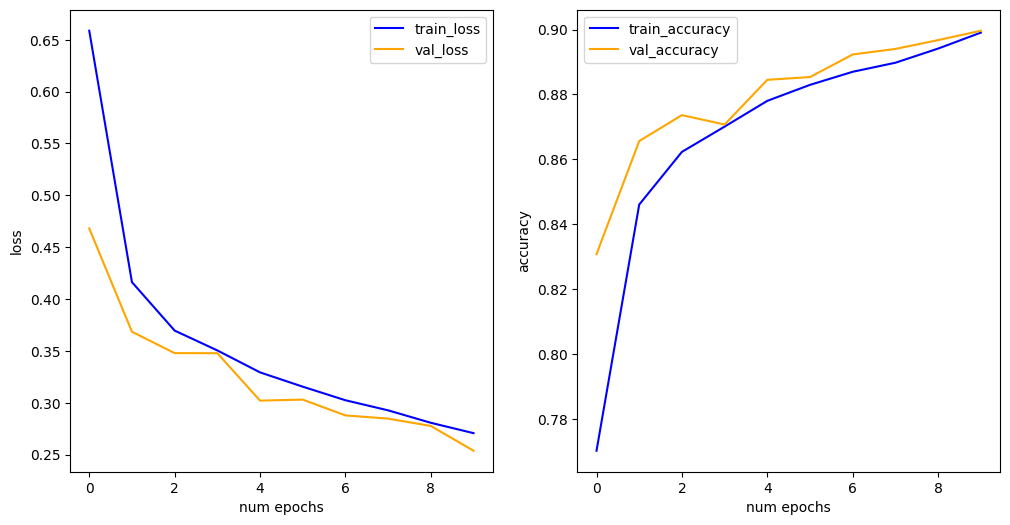

In [13]:
import matplotlib.pyplot as plt

net = MLP()
optimizer = optim.SGD(net.parameters(), lr=lr2, momentum=0.9)


validation_losses_batches, train_losses_batches, validation_accuracy_epochs, train_accuracy_epochs = train_model(net, trainloader, valloader, criterion, optimizer)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(train_losses_batches, c='blue', label='train_loss')
ax[0].plot(validation_losses_batches, c='orange', label='val_loss')
ax[1].plot(train_accuracy_epochs, c='blue', label='train_accuracy')
ax[1].plot(validation_accuracy_epochs, c='orange', label='val_accuracy')

ax[0].set_xlabel('num epochs')
ax[0].set_ylabel('loss')

ax[1].set_xlabel('num epochs')
ax[1].set_ylabel('accuracy')

ax[0].legend()
ax[1].legend()

plt.show()






- with lr=0.01 it is good but worse than 0.1 because we are training on few N_EPOCHS and it does'nt converge

Starting training for epoch 0
Train loss for epoch 0: 0.8301
Starting training for epoch 1
Train loss for epoch 1: 0.4880
Starting training for epoch 2
Train loss for epoch 2: 0.4308
Starting training for epoch 3
Train loss for epoch 3: 0.3953
Starting training for epoch 4
Train loss for epoch 4: 0.3747
Starting training for epoch 5
Train loss for epoch 5: 0.3537
Starting training for epoch 6
Train loss for epoch 6: 0.3409
Starting training for epoch 7
Train loss for epoch 7: 0.3284
Starting training for epoch 8
Train loss for epoch 8: 0.3159
Starting training for epoch 9
Train loss for epoch 9: 0.3033


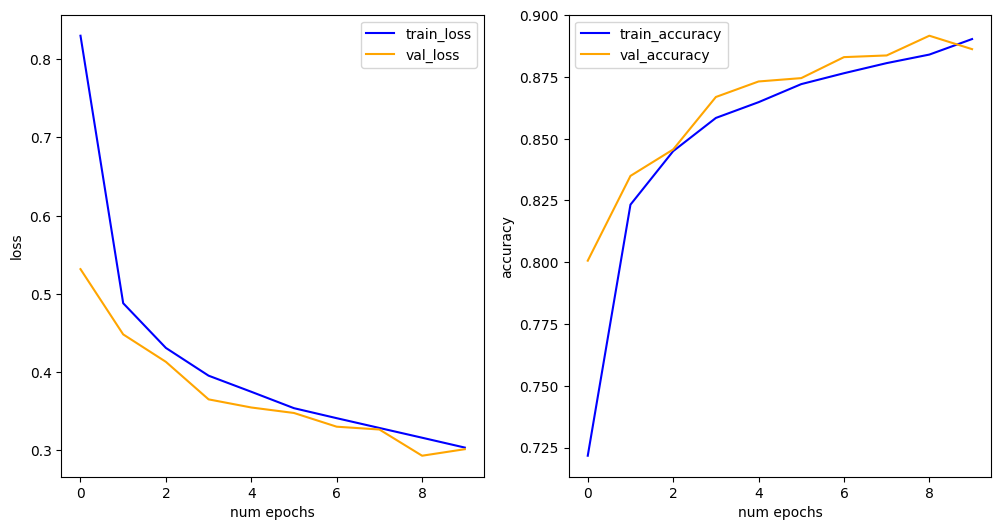

In [14]:
import matplotlib.pyplot as plt

net = MLP()
optimizer = optim.SGD(net.parameters(), lr=lr3, momentum=0.9)


validation_losses_batches, train_losses_batches, validation_accuracy_epochs, train_accuracy_epochs = train_model(net, trainloader, valloader, criterion, optimizer)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(train_losses_batches, c='blue', label='train_loss')
ax[0].plot(validation_losses_batches, c='orange', label='val_loss')
ax[1].plot(train_accuracy_epochs, c='blue', label='train_accuracy')
ax[1].plot(validation_accuracy_epochs, c='orange', label='val_accuracy')

ax[0].set_xlabel('num epochs')
ax[0].set_ylabel('loss')

ax[1].set_xlabel('num epochs')
ax[1].set_ylabel('accuracy')

ax[0].legend()
ax[1].legend()

plt.show()






## define CNN

In [36]:
n1 = 64
n2= 128

In [16]:

import torch.nn.functional as F
import torch.nn as nn


class CNN(nn.Module):
    def __init__(self, n1, n2):
        super().__init__()
        self.conv1 = nn.Conv2d(1, n1, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(n1) #number of channels as input
        self.pool = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(n1, n2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(n2)
        self.fc = nn.Linear(7*7*n2, NUM_CLASSES)
        self.dropout = nn.Dropout2d(0.1)
        

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.pool(x)
        x = torch.flatten(x, 1) #ci dice da che dimensione fare il flatten, cioe se ho piu batch e quindi x.size = (batch_size, 3, 28, 28)
        #alla fine avro x=(batch_size, 2352)
        x = self.fc(x) #logits presi da cross entropy loss criterion con softmax all'interno
        return x
    


**train**

Starting training for epoch 0
Train loss for epoch 0: 0.5217
Starting training for epoch 1
Train loss for epoch 1: 0.3078
Starting training for epoch 2
Train loss for epoch 2: 0.2723
Starting training for epoch 3
Train loss for epoch 3: 0.2467
Starting training for epoch 4
Train loss for epoch 4: 0.2336
Starting training for epoch 5
Train loss for epoch 5: 0.2221
Starting training for epoch 6
Train loss for epoch 6: 0.2168
Starting training for epoch 7
Train loss for epoch 7: 0.2046
Starting training for epoch 8
Train loss for epoch 8: 0.1976
Starting training for epoch 9
Train loss for epoch 9: 0.1864


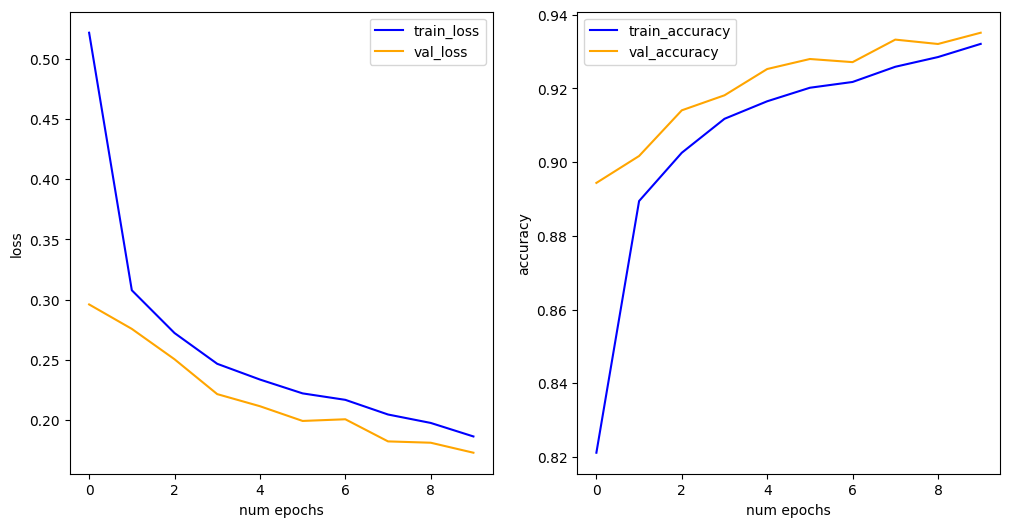

In [ ]:
import matplotlib.pyplot as plt

net = CNN(n1, n2)
optimizer = optim.SGD(net.parameters(), lr=lr2, momentum=0.9) #we can add regularization


validation_losses_batches, train_losses_batches, validation_accuracy_epochs, train_accuracy_epochs = train_model(net, trainloader, valloader, criterion, optimizer)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(train_losses_batches, c='blue', label='train_loss')
ax[0].plot(validation_losses_batches, c='orange', label='val_loss')
ax[1].plot(train_accuracy_epochs, c='blue', label='train_accuracy')
ax[1].plot(validation_accuracy_epochs, c='orange', label='val_accuracy')

ax[0].set_xlabel('num epochs')
ax[0].set_ylabel('loss')

ax[1].set_xlabel('num epochs')
ax[1].set_ylabel('accuracy')

ax[0].legend()
ax[1].legend()

plt.show()







- we notice that CNN works even better (obviously) and with more epochs could also improve

**study question**

-  If n1 = 64 and n2 = 128, what is the number of hyperparameters for the MLP
and the CNN architectures?

the number of hyperparameters does not depend on the network architecture, but depends on the choice that we make, for example: lr, weight decay, batch_size, n_epochs, optimizer ecc...

Instead, the number of parameters for:
- MLP: fc1 = (28*28 + 1 di bias)*n1 parameters + fc2 = (n1 + 1)*n2 parameters + fc3 = (n2 + 1)*10 parameters
- CNN: conv1 = (1x3x3 + 1)*n1 parameters + conv2 = (n1x3x3 + 1)*n2 parameters + fc = (7x7xn2 + 1)x10 parameters

**hyperparameter optimization**

I will do many trainings for different configurations (simulating RandomSearch) with a small n_epochs (e.g. 5), and then i will pick the best configuration and train the model for longer (30 epochs)

In [18]:
import random
import numpy as np
from torch import optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 5

param_distribution = {
    'n1': [32, 64, 128, 256],
    'n2': [32, 64, 128, 256],
    'weight_decay': [0, 1e-3, 1e-4, 1e-5],
    'batch_size': [64, 128, 256, 512],
    'lr': [1e-1, 1e-2, 1e-3, 1e-4],
    'momentum': [0.8, 0.9, 0.95],
    'optimizer': ['SGD', 'Adam', 'RMSprop', 'AdamW']  

}

n_iterations = 10 #simulate 10 iterations of RandomSearch
best_val_acc = 0
best_params = {}
results = []

for iter in range(n_iterations):

    #choose parameters for this run
    params = {
    'n1': random.choice(param_distribution['n1']),
    'n2': random.choice(param_distribution['n2']),
    'weight_decay': random.choice(param_distribution['weight_decay']),
    'batch_size': random.choice(param_distribution['batch_size']),
    'lr': random.choice(param_distribution['lr']),
    'momentum': random.choice(param_distribution['momentum']),
    'optimizer': random.choice(param_distribution['optimizer']) 
    }

    #initialize dataloaders
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=params['batch_size'], shuffle=True, num_workers=2, drop_last=True)
    valloader = torch.utils.data.DataLoader(validation_set, batch_size=params['batch_size'], shuffle=True, num_workers=2, drop_last=True)

    #initialize model
    net = CNN(n1=params['n1'], n2=params['n2'])

    parameters = net.parameters()
    lr = params['lr']
    
    #choose optimizer
    if (params['optimizer']=='SGD'):
        optimizer = optim.SGD(parameters, lr, params['momentum'], weight_decay=params['weight_decay'])

    elif (params['optimizer']=='Adam'):
        optimizer = optim.Adam(parameters, lr, weight_decay=params['weight_decay'])

    elif (params['optimizer']=='AdamW'):
        optimizer = optim.AdamW(parameters, lr, weight_decay=params['weight_decay'])
    
    elif (params['optimizer']=='RMSprop'):
        optimizer = optim.RMSprop(parameters, lr, momentum=params['momentum'], weight_decay=params['weight_decay'])

    #train model
    criterion = nn.CrossEntropyLoss()
    _, _, acc, _ = train_model(net, trainloader, valloader, criterion, optimizer)

    results.append({'accuracy': acc, 'params': params})

    if (acc[-1] > best_val_acc):
        print(f'New best model found!: accuracy {acc[-1]:.4f}')
        best_val_acc = acc[-1]
        best_params = params

print(f'\n{'='*50}')
print(f'The best model is:\n ACCURACY {best_val_acc:.4f}\n')
for key, value in best_params.items():
    print(f'{key}: {value}')




Starting training for epoch 0
Train loss for epoch 0: 0.6135
Starting training for epoch 1
Train loss for epoch 1: 0.3388
Starting training for epoch 2
Train loss for epoch 2: 0.3052
Starting training for epoch 3
Train loss for epoch 3: 0.2890
Starting training for epoch 4
Train loss for epoch 4: 0.2723
New best model found!: accuracy 0.9107
Starting training for epoch 0
Train loss for epoch 0: 1.0621
Starting training for epoch 1
Train loss for epoch 1: 0.6809
Starting training for epoch 2
Train loss for epoch 2: 0.6002
Starting training for epoch 3
Train loss for epoch 3: 0.5525
Starting training for epoch 4
Train loss for epoch 4: 0.5214
Starting training for epoch 0
Train loss for epoch 0: 1.3482
Starting training for epoch 1
Train loss for epoch 1: 0.3491
Starting training for epoch 2
Train loss for epoch 2: 0.3113
Starting training for epoch 3
Train loss for epoch 3: 0.2952
Starting training for epoch 4
Train loss for epoch 4: 0.2826
Starting training for epoch 0
Train loss for e

Now we train the best model for 30 EPOCHS

In [23]:
def train_model(model, train_loader, val_loader, criterion, optimizer, version):
    patience = 4
    validation_losses_epochs = [] #contains losses after each batch
    train_losses_epochs = [] #same

    train_accuracy_epochs = []
    validation_accuracy_epochs = []

    model.to(device)

    best_val_acc = 0
    epochs_without_improvement = 0

    for epoch in range(NUM_EPOCHS):
        model.train()
        train_corrects = 0
        total_loss = 0
        num_samples = 0
        print(f'Starting training for epoch {epoch}')


        for i, batch in enumerate(train_loader):

            bs = batch[0].shape[0]
            num_samples += bs
            images, targets = batch
            images , targets = images.to(device), targets.to(device)

            optimizer.zero_grad()

            preds= model(images) 
            #preds e un tensore di logits, quindi per ogni immagine, c'e un tensore 1d con i logit, uno per classe
            # --> il primo indice, cioe l'indice del'intero vettore logits, indica l'immagine a cui il vettore si riferisce
            # --> l'indice dentro i logits corrisponde al numero del target rispetto al quale e stato calcolato quel logit
            #in tutto cio lo shape ha sempre (batch_size,) all'inizio

            _, targets_pred = torch.max(preds, 1)

            train_corrects += torch.sum(targets == targets_pred).item()

            loss = criterion(preds, targets)

            loss.backward()

            optimizer.step()

            
            total_loss += loss.item() * bs
        
        train_losses_epochs.append(total_loss/num_samples)
        
        print(f'Train loss for epoch {epoch}: {total_loss/num_samples:.4f}')
        
        train_accuracy_epochs.append(1.0*train_corrects/float(num_samples))
        


        model.eval()
        val_corrects = 0
        total_loss=0
        num_samples = 0

        with torch.no_grad():
            for batch in val_loader:
                images, targets = batch
                images, targets = images.to(device), targets.to(device) 

                bs = batch[0].shape[0]
                num_samples+=bs
                preds = model(images)

                _, targets_pred = torch.max(preds, 1) #prendo, per ogni tensore logit (percio c'e dim=1, gli stiamo dicendo di calcolare il massimo per ogni singolo vettore logit, non un solo massimo tra tutti i vettori logit), l'indice del logit massimo, ovvero il target con probabilita maggiore
                #cioe che ritorna e un vettore con tutti i logits massimi, uno per immagine appunto
                #e gli indici interni al vettore di logits associati ai singoli logit massimi, ovvero i target, che sono quelli che prendiamo e che ci interessano
                #in tutto cio lo shape ha sempre (batch_size,) all'inizio

                val_corrects += torch.sum(targets == targets_pred).item()

                loss = criterion(preds, targets)

                total_loss += loss.item() * bs

            val_acc = 1.0*val_corrects/float(num_samples)
            validation_accuracy_epochs.append(val_acc)
            validation_losses_epochs.append(total_loss/num_samples)

            if (val_acc > best_val_acc):
                best_val_acc = val_acc
                epochs_without_improvement = 0
                torch.save(model.state_dict(), f'best_model{version}.pth')
            
            else:
                epochs_without_improvement +=1
            
            if epochs_without_improvement >= patience:
                print(f'Early stopping at epoch {epoch}. Best val acc: {best_val_acc:.4f}')
                break
            

            

    return validation_losses_epochs, train_losses_epochs, validation_accuracy_epochs, train_accuracy_epochs

Starting training for epoch 0
Train loss for epoch 0: 0.4671
Starting training for epoch 1
Train loss for epoch 1: 0.3365
Starting training for epoch 2
Train loss for epoch 2: 0.3026
Starting training for epoch 3
Train loss for epoch 3: 0.2839
Starting training for epoch 4
Train loss for epoch 4: 0.2664
Starting training for epoch 5
Train loss for epoch 5: 0.2526
Starting training for epoch 6
Train loss for epoch 6: 0.2447
Starting training for epoch 7
Train loss for epoch 7: 0.2381
Starting training for epoch 8
Train loss for epoch 8: 0.2290
Starting training for epoch 9
Train loss for epoch 9: 0.2226
Starting training for epoch 10
Train loss for epoch 10: 0.2212
Starting training for epoch 11
Train loss for epoch 11: 0.2150
Starting training for epoch 12
Train loss for epoch 12: 0.2142
Starting training for epoch 13
Train loss for epoch 13: 0.2080
Starting training for epoch 14
Train loss for epoch 14: 0.2055
Starting training for epoch 15
Train loss for epoch 15: 0.2018
Early stoppi

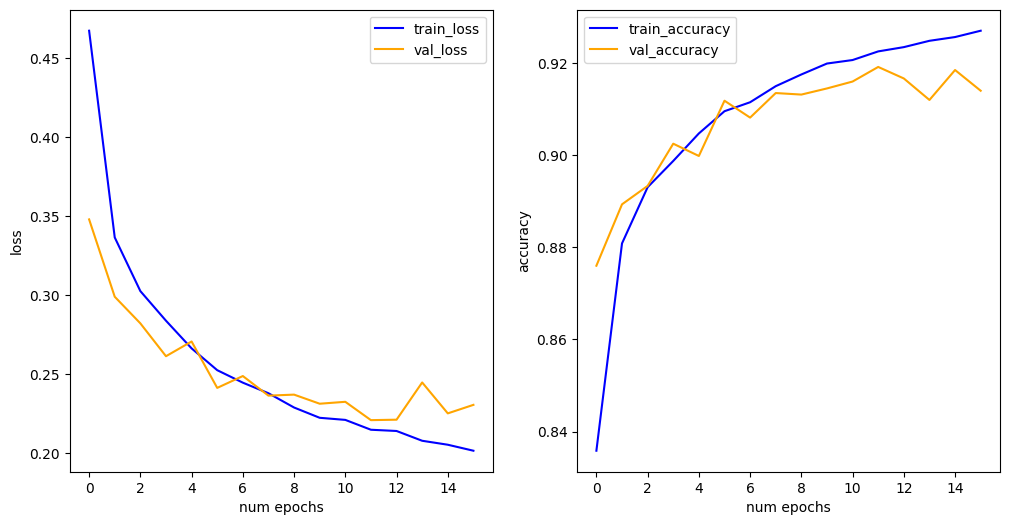

In [26]:
#TRAIN 1
import matplotlib.pyplot as plt
NUM_EPOCHS = 50

n1 = 64
n2 = 32
weight_decay= 0.0001
batch_size= 128
lr= 0.0001
momentum = 0.9

net1 = CNN(n1, n2)
criterion = nn.CrossEntropyLoss()

optimizer = optim.RMSprop(net1.parameters(), lr, weight_decay=weight_decay, momentum=momentum)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
valloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False)

validation_losses_batches, train_losses_batches, validation_accuracy_epochs, train_accuracy_epochs = train_model(net1, trainloader, valloader, criterion, optimizer, version=1)

print(f'final ACCURACY on validation set: {validation_accuracy_epochs[-1]}')


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(train_losses_batches, c='blue', label='train_loss')
ax[0].plot(validation_losses_batches, c='orange', label='val_loss')
ax[1].plot(train_accuracy_epochs, c='blue', label='train_accuracy')
ax[1].plot(validation_accuracy_epochs, c='orange', label='val_accuracy')

ax[0].set_xlabel('num epochs')
ax[0].set_ylabel('loss')

ax[1].set_xlabel('num epochs')
ax[1].set_ylabel('accuracy')

ax[0].legend()
ax[1].legend()

plt.show()









Starting training for epoch 0
Train loss for epoch 0: 0.4681
Starting training for epoch 1
Train loss for epoch 1: 0.3343
Starting training for epoch 2
Train loss for epoch 2: 0.2957
Starting training for epoch 3
Train loss for epoch 3: 0.2775
Starting training for epoch 4
Train loss for epoch 4: 0.2658
Starting training for epoch 5
Train loss for epoch 5: 0.2541
Starting training for epoch 6
Train loss for epoch 6: 0.2442
Starting training for epoch 7
Train loss for epoch 7: 0.2406
Starting training for epoch 8
Train loss for epoch 8: 0.2291
Starting training for epoch 9
Train loss for epoch 9: 0.2278
Starting training for epoch 10
Train loss for epoch 10: 0.2233
Starting training for epoch 11
Train loss for epoch 11: 0.2150
Starting training for epoch 12
Train loss for epoch 12: 0.2108
Starting training for epoch 13
Train loss for epoch 13: 0.2066
Starting training for epoch 14
Train loss for epoch 14: 0.2053
Starting training for epoch 15
Train loss for epoch 15: 0.2036
Starting tra

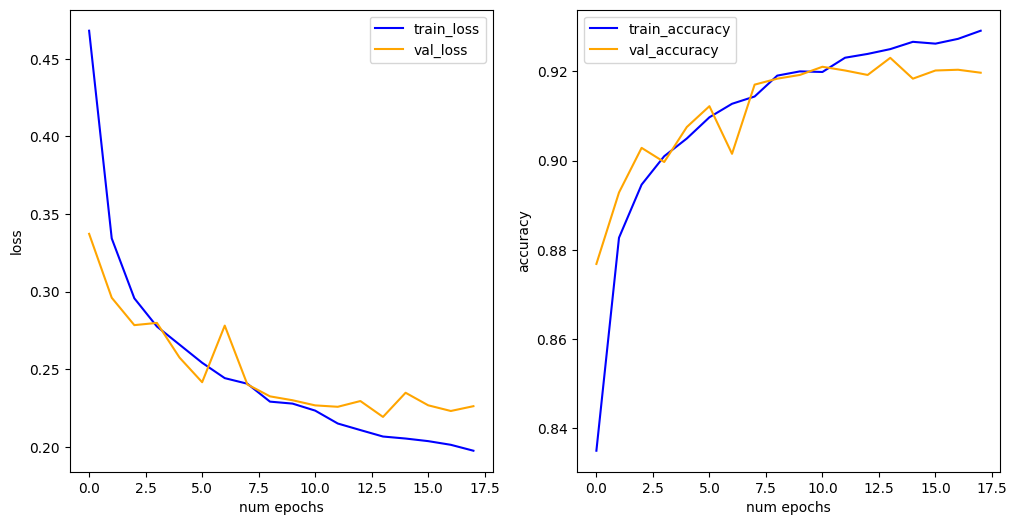

In [27]:
#TRAIN 2
import matplotlib.pyplot as plt
NUM_EPOCHS = 50

n1 = 64
n2 = 32
weight_decay= 0.0001
batch_size= 128
lr= 0.0001
momentum = 0.9

net2 = CNN(n1, n2)
criterion = nn.CrossEntropyLoss()

optimizer = optim.RMSprop(net2.parameters(), lr, weight_decay=weight_decay, momentum=momentum)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
valloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False)

validation_losses_batches, train_losses_batches, validation_accuracy_epochs, train_accuracy_epochs = train_model(net2, trainloader, valloader, criterion, optimizer, version=2)

print(f'final ACCURACY on validation set: {validation_accuracy_epochs[-1]}')


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(train_losses_batches, c='blue', label='train_loss')
ax[0].plot(validation_losses_batches, c='orange', label='val_loss')
ax[1].plot(train_accuracy_epochs, c='blue', label='train_accuracy')
ax[1].plot(validation_accuracy_epochs, c='orange', label='val_accuracy')

ax[0].set_xlabel('num epochs')
ax[0].set_ylabel('loss')

ax[1].set_xlabel('num epochs')
ax[1].set_ylabel('accuracy')

ax[0].legend()
ax[1].legend()

plt.show()









Starting training for epoch 0
Train loss for epoch 0: 0.4650
Starting training for epoch 1
Train loss for epoch 1: 0.3326
Starting training for epoch 2
Train loss for epoch 2: 0.2974
Starting training for epoch 3
Train loss for epoch 3: 0.2789
Starting training for epoch 4
Train loss for epoch 4: 0.2661
Starting training for epoch 5
Train loss for epoch 5: 0.2577
Starting training for epoch 6
Train loss for epoch 6: 0.2458
Starting training for epoch 7
Train loss for epoch 7: 0.2397
Starting training for epoch 8
Train loss for epoch 8: 0.2307
Starting training for epoch 9
Train loss for epoch 9: 0.2286
Starting training for epoch 10
Train loss for epoch 10: 0.2233
Starting training for epoch 11
Train loss for epoch 11: 0.2154
Starting training for epoch 12
Train loss for epoch 12: 0.2101
Starting training for epoch 13
Train loss for epoch 13: 0.2097
Starting training for epoch 14
Train loss for epoch 14: 0.2067
Starting training for epoch 15
Train loss for epoch 15: 0.2046
Starting tra

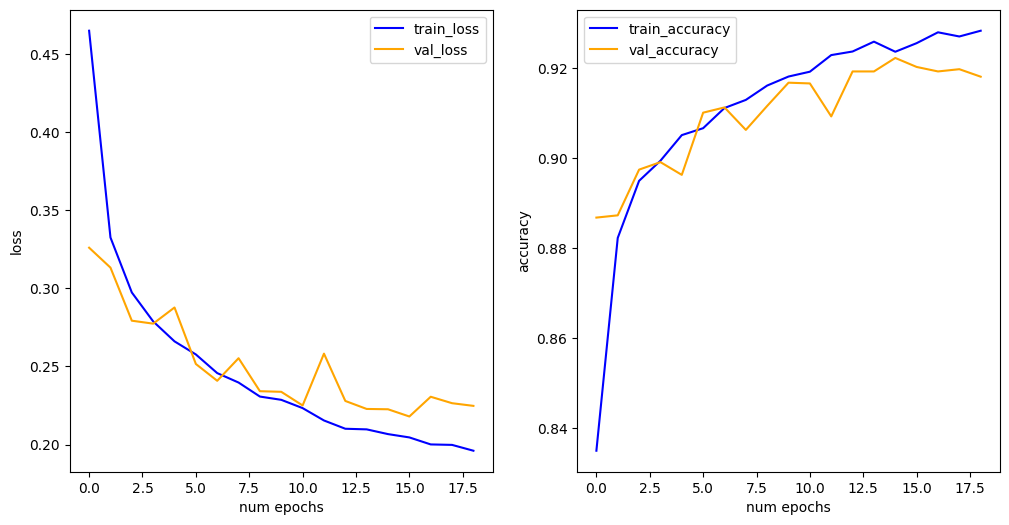

In [28]:
#TRAIN 3
import matplotlib.pyplot as plt
NUM_EPOCHS = 50

n1 = 64
n2 = 32
weight_decay= 0.0001
batch_size= 128
lr= 0.0001
momentum = 0.9

net3 = CNN(n1, n2)
criterion = nn.CrossEntropyLoss()

optimizer = optim.RMSprop(net3.parameters(), lr, weight_decay=weight_decay, momentum=momentum)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
valloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False)

validation_losses_batches, train_losses_batches, validation_accuracy_epochs, train_accuracy_epochs = train_model(net3, trainloader, valloader, criterion, optimizer, version=3)

print(f'final ACCURACY on validation set: {validation_accuracy_epochs[-1]}')


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(train_losses_batches, c='blue', label='train_loss')
ax[0].plot(validation_losses_batches, c='orange', label='val_loss')
ax[1].plot(train_accuracy_epochs, c='blue', label='train_accuracy')
ax[1].plot(validation_accuracy_epochs, c='orange', label='val_accuracy')

ax[0].set_xlabel('num epochs')
ax[0].set_ylabel('loss')

ax[1].set_xlabel('num epochs')
ax[1].set_ylabel('accuracy')

ax[0].legend()
ax[1].legend()

plt.show()









**study question**

Why and how much does the accuracy change between different training runs?

It changes by little amounts because of different stochastic behaviours:
- Data Augmentation: random flips makes every epoch seeing different versions of images --> difference
- Weight Initialization: we didn't set an initialization for the model, so it is random and make the performance change
- Data Shuffling: we shuffle in dataloaders, so every epoch sees different sorting in batches
- Dropout: stochastic elimination of layer units (neurons)


## run tests

In [29]:
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform_test, download=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False)


In [30]:
#TEST1
total_loss=0
num_samples = 0
val_corrects = 0
net1.load_state_dict(torch.load('best_model1.pth'))

net1.to(device)
net1.eval()
with torch.no_grad():
    for batch in testloader:
        images, targets = batch
        images, targets = images.to(device), targets.to(device) 

        bs = batch[0].shape[0]
        num_samples+=bs
        preds = net1(images)

        _, targets_pred = torch.max(preds, 1) #prendo, per ogni tensore logit (percio c'e dim=1, gli stiamo dicendo di calcolare il massimo per ogni singolo vettore logit, non un solo massimo tra tutti i vettori logit), l'indice del logit massimo, ovvero il target con probabilita maggiore
        #cioe che ritorna e un vettore con tutti i logits massimi, uno per immagine appunto
        #e gli indici interni al vettore di logits associati ai singoli logit massimi, ovvero i target, che sono quelli che prendiamo e che ci interessano
        #in tutto cio lo shape ha sempre (batch_size,) all'inizio

        val_corrects += torch.sum(targets == targets_pred).item()

    acc_test = 100*1.0*val_corrects/float(num_samples)

    print(f'TEST1 ACCURACY: {acc_test}')

C:\Users\Utente\AppData\Local\Temp\ipykernel_41620\42717743.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net1.load_state_dict(torch.load('best_model1.pth'))


TEST1 ACCURACY: 91.45


In [31]:
#TEST2
total_loss=0
num_samples = 0
val_corrects = 0
net2.load_state_dict(torch.load('best_model2.pth'))

net2.to(device)
net2.eval()
with torch.no_grad():
    for batch in testloader:
        images, targets = batch
        images, targets = images.to(device), targets.to(device) 

        bs = batch[0].shape[0]
        num_samples+=bs
        preds = net2(images)

        _, targets_pred = torch.max(preds, 1) #prendo, per ogni tensore logit (percio c'e dim=1, gli stiamo dicendo di calcolare il massimo per ogni singolo vettore logit, non un solo massimo tra tutti i vettori logit), l'indice del logit massimo, ovvero il target con probabilita maggiore
        #cioe che ritorna e un vettore con tutti i logits massimi, uno per immagine appunto
        #e gli indici interni al vettore di logits associati ai singoli logit massimi, ovvero i target, che sono quelli che prendiamo e che ci interessano
        #in tutto cio lo shape ha sempre (batch_size,) all'inizio

        val_corrects += torch.sum(targets == targets_pred).item()

    acc_test = 100*1.0*val_corrects/float(num_samples)

    print(f'TEST1 ACCURACY: {acc_test}')

C:\Users\Utente\AppData\Local\Temp\ipykernel_41620\1977701407.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net2.load_state_dict(torch.load('best_model2.pth'))


TEST1 ACCURACY: 91.39


In [32]:
#TEST3
total_loss=0
num_samples = 0
val_corrects = 0
net3.load_state_dict(torch.load('best_model3.pth'))

net3.to(device)
net3.eval()
with torch.no_grad():
    for batch in testloader:
        images, targets = batch
        images, targets = images.to(device), targets.to(device) 

        bs = batch[0].shape[0]
        num_samples+=bs
        preds = net3(images)

        _, targets_pred = torch.max(preds, 1) #prendo, per ogni tensore logit (percio c'e dim=1, gli stiamo dicendo di calcolare il massimo per ogni singolo vettore logit, non un solo massimo tra tutti i vettori logit), l'indice del logit massimo, ovvero il target con probabilita maggiore
        #cioe che ritorna e un vettore con tutti i logits massimi, uno per immagine appunto
        #e gli indici interni al vettore di logits associati ai singoli logit massimi, ovvero i target, che sono quelli che prendiamo e che ci interessano
        #in tutto cio lo shape ha sempre (batch_size,) all'inizio

        val_corrects += torch.sum(targets == targets_pred).item()

    acc_test = 100*1.0*val_corrects/float(num_samples)

    print(f'TEST1 ACCURACY: {acc_test}')

C:\Users\Utente\AppData\Local\Temp\ipykernel_41620\3291877528.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net3.load_state_dict(torch.load('best_model3.pth'))


TEST1 ACCURACY: 91.25
